In [1]:
import matplotlib.pyplot as plt
import nibabel
import numpy as np
import pandas as pd
from pathlib import Path
from skimage.transform import rescale
from tqdm import tqdm

In [2]:
import scipy
def compute_kl(img, brain, mask, _bin_heuristics = 'sturges'):
    size, _bins = np.histogram(img[brain.astype(bool)], bins = _bin_heuristics)
    bins = [(_bins[i]+_bins[i+1])/2 for i in range(len(_bins)-1)]

    size_healthy, bin_edges = np.histogram(img[brain.astype(bool)^mask.astype(bool)].reshape(-1), bins=_bins)
    size_tumor, _ = np.histogram(img[mask.astype(bool)].reshape(-1), bins = _bins)

    size_healthy = np.round(size_healthy/size_healthy.sum(), 5)
    size_tumor = np.round(size_tumor/size_tumor.sum(), 5)
    
    size_healthy = np.where(size_healthy>10e-6, size_healthy, 10e-6)
    size_tumor = np.where(size_tumor>10e-6, size_tumor, 10e-6)

#     kl_dist = 0
#     for h,t in zip(size_healthy, size_tumor):
#         kl_dist += h * np.log2(h/t)

    kl_dist = scipy.spatial.distance.jensenshannon(size_healthy, size_tumor)
        
            
    return kl_dist, size_healthy, size_tumor, _bins

In [3]:
def compute_emd(img, brain, mask):
    size, _bins = np.histogram(img[brain.astype(bool)], bins = 100)
    bins = [(_bins[i]+_bins[i+1])/2 for i in range(len(_bins)-1)]

    size_healthy, _ = np.histogram(img[brain.astype(bool)^mask.astype(bool)].reshape(-1), bins=_bins)
    size_tumor, _ = np.histogram(img[mask.astype(bool)].reshape(-1), bins=_bins -1 )

#     size_healthy = np.round(size_healthy/size_healthy.sum(), 5)
#     size_tumor = np.round(size_tumor/size_tumor.sum(), 5)
    
#     size_healthy = np.where(size_healthy>10e-6, size_healthy, 10e-6)
#     size_tumor = np.where(size_tumor>10e-6, size_tumor, 10e-6)

    emd = scipy.stats.wasserstein_distance(size_healthy, size_tumor)
            
    return emd, size_healthy, size_tumor, _bins

In [4]:
dataset = 'schw'
main_img = 'T1.nii.gz'
label_name = 'T1_SEG.nii.gz'
mask_name = 'T1_mask.nii.gz'

In [6]:
root = Path('/anvar/public_datasets/preproc_study/{}/4a_resamp/'.format(dataset)) 

all_kl = []

for patient in tqdm(root.glob('*')):
    if patient.is_dir():
        img = nibabel.load(patient / main_img).get_fdata()
        mask = nibabel.load(patient / label_name).get_fdata()
        brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                             str(patient).split('/')[-1] +'/' + mask_name).get_fdata()
        
        kl, _, _, _ = compute_kl(img, brain, mask)
        all_kl.append(kl)

243it [05:35,  1.38s/it]


In [7]:
root2 = Path('/anvar/public_datasets/preproc_study/{}/4d_susan'.format(dataset))

all_kl_susan = []

for patient in tqdm(root2.glob('*')):
    if patient.is_dir():
        try:
            img = nibabel.load(patient / main_img).get_fdata()
            mask = nibabel.load(patient / label_name).get_fdata()
            brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                                 str(patient).split('/')[-1] +'/' + mask_name).get_fdata()


            kl, _, _, _ = compute_kl(img, brain, mask)
            all_kl_susan.append(kl)
        except:
            pass

243it [03:36,  1.12it/s]


In [8]:
root2 = Path('/anvar/public_datasets/preproc_study/{}/6_hist/6_hist_fold_0/'.format(dataset))

all_kl_hist = []

for patient in tqdm(root2.glob('*')):
    if patient.is_dir():
        try:
            img = nibabel.load(patient / main_img).get_fdata()
            mask = nibabel.load(patient / label_name).get_fdata()
            brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                                 str(patient).split('/')[-1] +'/' + mask_name).get_fdata()

            kl, _, _, _ = compute_kl(img, brain, mask)
            all_kl_hist.append(kl)
        except:
            pass

242it [04:47,  1.19s/it]


In [9]:
root2 = Path('/anvar/public_datasets/preproc_study/{}/4b_n4/'.format(dataset))

all_kl_n4 = []

for patient in tqdm(root2.glob('*')):
    if patient.is_dir():
        try:
            img = nibabel.load(patient / main_img).get_fdata()
            mask = nibabel.load(patient / label_name).get_fdata()
            brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                                 str(patient).split('/')[-1] +'/' + mask_name).get_fdata()

            kl, _, _, _ = compute_kl(img, brain, mask)
            all_kl_n4.append(kl)
        except:
            pass

243it [04:41,  1.16s/it]


In [10]:
root2 = Path('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset))

all_kl_ss = []

for patient in tqdm(root2.glob('*')):
    if patient.is_dir():
        try:
            img = nibabel.load(patient / main_img).get_fdata()
            mask = nibabel.load(patient / label_name).get_fdata()
            brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                                 str(patient).split('/')[-1] +'/' + mask_name).get_fdata()

            kl, _, _, _ = compute_kl(img, brain, mask)
            all_kl_ss.append(kl)
        except:
            pass

243it [02:48,  1.45it/s]


In [11]:
from researchpy import ttest

def ttest_pair(df_1, df_2, name_1 = 'one', name_2 = 'two', correction = None):
    return ttest(pd.Series(df_1), pd.Series(df_2), 
#                  group1_name = name_1,
#                  group2_name= name_2, 
                 equal_variances=False, paired=True, correction = 8).iloc[4].values[1]

In [18]:
pivot = pd.DataFrame(columns = ['Mean(STD)', 'P-value'])
pivot.at[0,'Mean(STD)'] =  str(np.round(np.mean(all_kl),3)) + ' (' + str(np.round(np.std(all_kl),3)) +')'
pivot.at[1,'Mean(STD)'] =  str(np.round(np.mean(all_kl_n4),3)) + ' (' + str(np.round(np.std(all_kl_n4),3)) +')'
pivot.at[1,'P-value'] =  str(np.round(ttest_pair(all_kl, all_kl_n4),3)) 
pivot.at[2,'Mean(STD)'] =  str(np.round(np.mean(all_kl_susan),3)) + ' (' + str(np.round(np.std(all_kl_susan),3)) +')'
pivot.at[2,'P-value'] =  str(np.round(ttest_pair(all_kl, all_kl_susan),3)) 
pivot.at[3,'Mean(STD)'] =  str(np.round(np.mean(all_kl_hist),3)) + ' (' + str(np.round(np.std(all_kl_hist),3)) +')'
pivot.at[3,'P-value'] =  str(np.round(ttest_pair(all_kl, all_kl_hist),3)) 
pivot.at[4,'Mean(STD)'] =  str(np.round(np.mean(all_kl_ss),3)) + ' (' + str(np.round(np.std(all_kl_ss),3)) +')'
pivot.at[4,'P-value'] =  str(np.round(ttest_pair(all_kl, all_kl_ss),3)) 

In [20]:
def compute_cdf(img, brain, mask, _bin_heuristics = 'sturges'):
    size_brain, _bins = np.histogram(img[brain.astype(bool)], bins = _bin_heuristics, density=True)
    size_brain = size_brain/size_brain.sum()

    size_healthy, _ = np.histogram(img[brain.astype(bool)^mask.astype(bool)].reshape(-1), bins=_bins, density=True)
    size_tumor, _ = np.histogram(img[mask.astype(bool)].reshape(-1), bins = _bins, density=True)

    size_healthy = size_healthy/size_healthy.sum()
    size_tumor = size_tumor/size_tumor.sum()
    
    cdf_brain = np.cumsum(size_brain)
    cdf_healthy = np.cumsum(size_healthy)
    cdf_tumor = np.cumsum(size_tumor)
        
            
    return cdf_brain, cdf_healthy, cdf_tumor, _bins

242it [05:11,  1.29s/it]


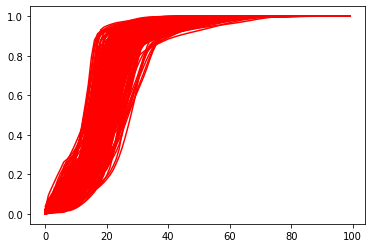

In [27]:
dataset = 'schw'
main_img = 'T1.nii.gz'
label_name = 'T1_SEG.nii.gz'
mask_name = 'T1_mask.nii.gz'
root = Path('/anvar/public_datasets/preproc_study/{}/6_hist/6_hist_fold_0/'.format(dataset)) 

for patient in tqdm(root.glob('*')):
    if patient.is_dir():
        img = nibabel.load(patient / main_img).get_fdata()
        mask = nibabel.load(patient / label_name).get_fdata()
        brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                             str(patient).split('/')[-1] +'/' + mask_name).get_fdata()
        
        cdf_brain, cdf_healthy, cdf_tumor, _bins = compute_cdf(img, brain, mask, _bin_heuristics = 100)
        plt.plot(cdf_brain, 'r')
plt.show()

242it [03:55,  1.03it/s]


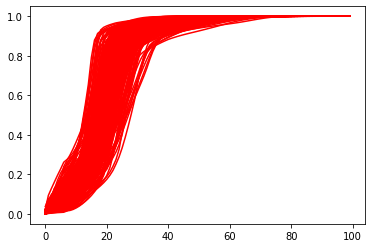

In [28]:
for patient in tqdm(root.glob('*')):
    if patient.is_dir():
        img = nibabel.load(patient / main_img).get_fdata()
        mask = nibabel.load(patient / label_name).get_fdata()
        brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                             str(patient).split('/')[-1] +'/' + mask_name).get_fdata()
        
        cdf_brain, cdf_healthy, cdf_tumor, _bins = compute_cdf(img, brain, mask, _bin_heuristics = 100)
        plt.plot(cdf_healthy, 'r')
plt.show()

242it [03:29,  1.16it/s]


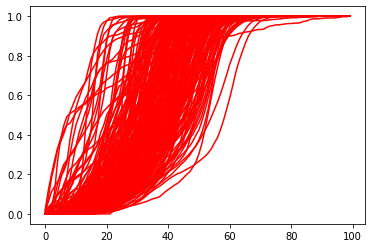

In [29]:
for patient in tqdm(root.glob('*')):
    if patient.is_dir():
        img = nibabel.load(patient / main_img).get_fdata()
        mask = nibabel.load(patient / label_name).get_fdata()
        brain = nibabel.load('/anvar/public_datasets/preproc_study/{}/5_ss_shared/'.format(dataset) +
                             str(patient).split('/')[-1] +'/' + mask_name).get_fdata()
        
        cdf_brain, cdf_healthy, cdf_tumor, _bins = compute_cdf(img, brain, mask, _bin_heuristics = 100)
        plt.plot(cdf_tumor, 'r')
plt.show()